# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 7

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [ ]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

Populating the interactive namespace from numpy and matplotlib


#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**:
Дело в том, что метод predict_proba возвращает массив, в котором столбцами являются вероятности того, что объект принадлежит к данному классу. Эти вероятности оцениваются классификатором. То есть, поскольку у нас сейчас классификатор просто выдает равновероятно либо положительный, либо отрицательный классы - то на каждом объекте вероятность принадлежности к каждому из двух классов по 1/2. Мы берем второй столбец в данном случае, то есть, столбец с вероятностью принадлежности элемента к положительному классу.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


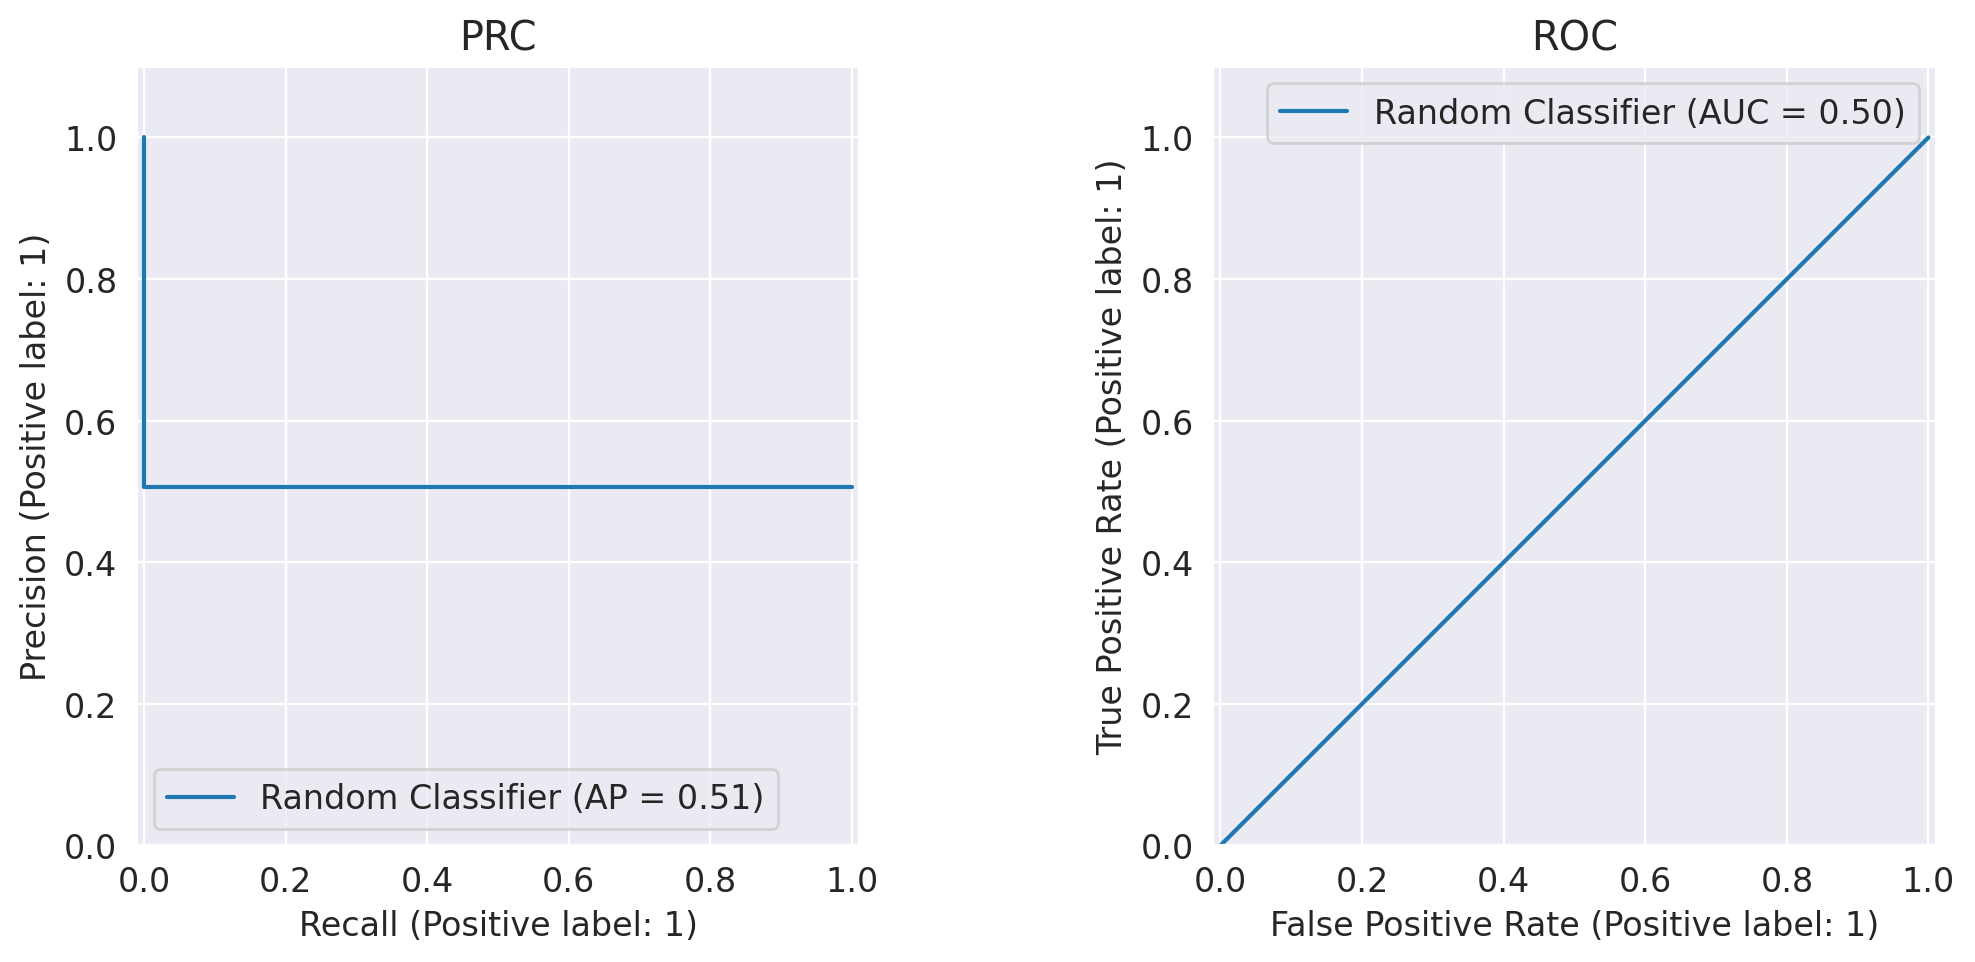

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# your code
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

dict_with_cs = {'C': np.logspace(0, 5, 20)}

searcher = GridSearchCV(LinearSVC(max_iter=1000), param_grid = dict_with_cs, scoring="average_precision", cv=10)
searcher.fit(X_train, y_train)

best_c = searcher.best_params_['C']
svc = LinearSVC(max_iter=1000, C=best_c).fit(X_train, y_train)
svc_pred = svc.predict(X_test)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM Classifier metrics
AUC-PR: 0.7141
AUC-ROC: 0.7717


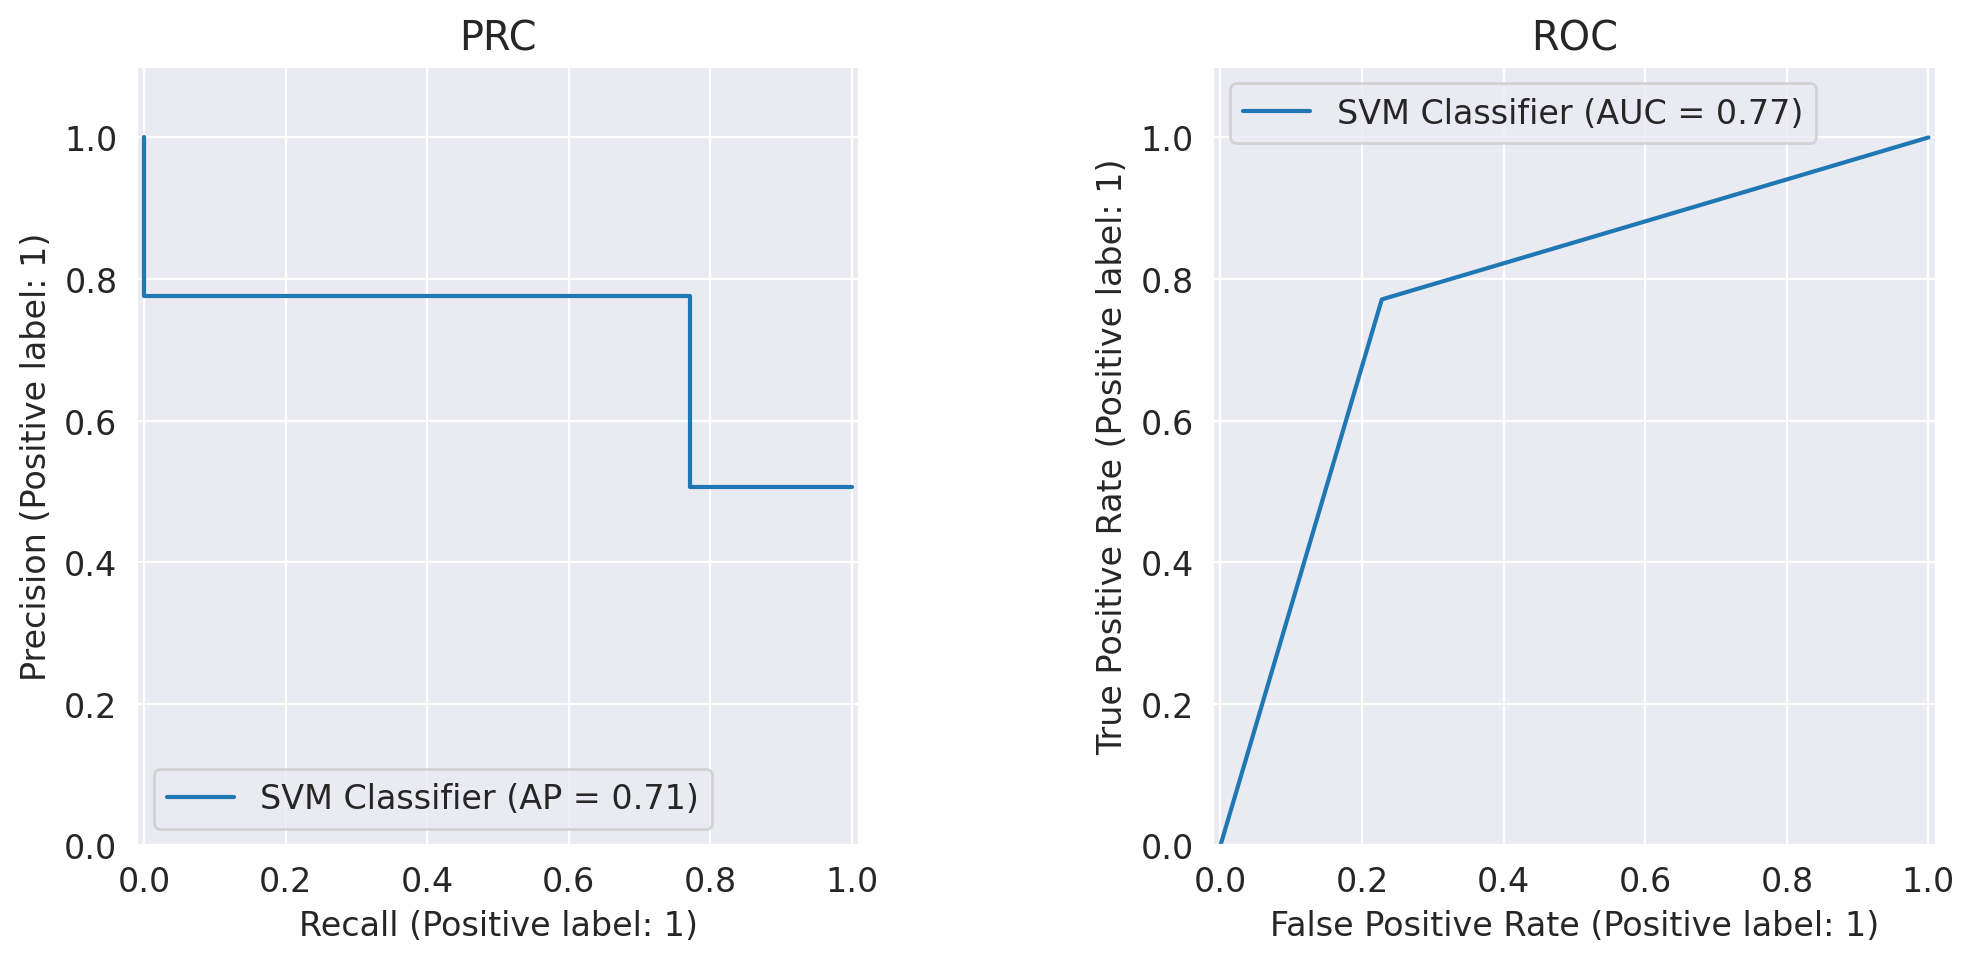

In [ ]:
# your code here
depict_pr_roc(y_test, svc_pred, 'SVM Classifier')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Во-первых, стоит сказать, что наименьший порог находится в самой крайней правой точке, когда рекол нулевой. Когда мы увеличиваем порог - то рекол падает, поскольку теперь мы не все положительные объекты будем относить к положительному классу, поскольку, когда, это нетривиальные объекты положительного класса, то в них уверенность низкая и мы их будем относить к отрицательному классу при увеличении порога. При этом, precision возрастает, поскольку к положительному классу мы начинаем относить только те объекты, в которых мы наиболее уверенны, а значит, и ошибаться модель будет меньше. При этом, на графике можно заметить и резкий скачок. Он объясняется тем, что скорее всего, у нас лежит много объектов отрицательного класса подряд. И FP-rate начинает сильно падать. Затем количество этих объектов с каким-то порогом уже становится меньше и у нас появляется больше объектов положительного класса. То есть, при большом пороге, у нас скорее всего будут встречаться то объекты положительного класса - то отрицательного(какие-то нетривиальные), а потому не будет таких резких скачков precision. Кроме случая совсем большого порога, когда там скорее всего идут в основном объекты положительного класса.


---



Теперь проинтерпретируем AUC-ROC. Дело в том, что когда у нас порог высокий (мы находимся около точки (0,0) - то скорее всего, поскольку у нас уже более менее хорошая модель - объектов с реально положительным классом много, а с реально отрицательным - мало. Поэтому, при смещении порога, то есть, при его уменьшении, мы будем намного чаще сначала смещаться вверх, чем вправо, поскольку много объектов положительного класса. Но чем ниже порог - тем менее уверена модель в том, что это объект положительного класса и у нас начинают постепенно появляться все больше объектов отрицательного класса - и мы уже при смещении порога чаще начинаем смещаться вправо, чем вверх, поскольку чаще начинаем относить отрицательные объекты к положительному классу, так как их просто больше. Если в задаче требуется объяснить логику именно с увеличением порога - то когда у нас порог очень низкий - то у нас много отрицательных объектов и мало положительных. Поэтому, когда мы начинаем его увеличивать - то довольно часто будем переставать относить объекты отрицательного класса к положительному, а потому, будем часто смещаться влево, а не вниз, поскольку смещение вниз означает, что мы объект положительного класса отнесли к отрицательному, увеличив порог. В какой-то момент объектов положительного класса становится больше и мы уже начинаем часто смещаться вниз.



---

Если смотреть на графики, то можно сделать вывод о том, что PRC кривая нестрого убывает при уменьшении порога, а AUC-ROC кривая монотонно возрастает при уменьшении порога. Но поскольку мы знаем, что на самом деле ROC - кривая строится ступеньками (этих ступенек просто мы не видим), то  ROC-кривая нестрого возрастающая. Что касается PRC-кривой - то она вообще не монотонная, поскольку у нас могут чередоваться объекты положительного и отрицательного класса и PRC то возрастать - то убывать.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

SVM Classifier metrics
AUC-PR: 0.7141
AUC-ROC: 0.7717
Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


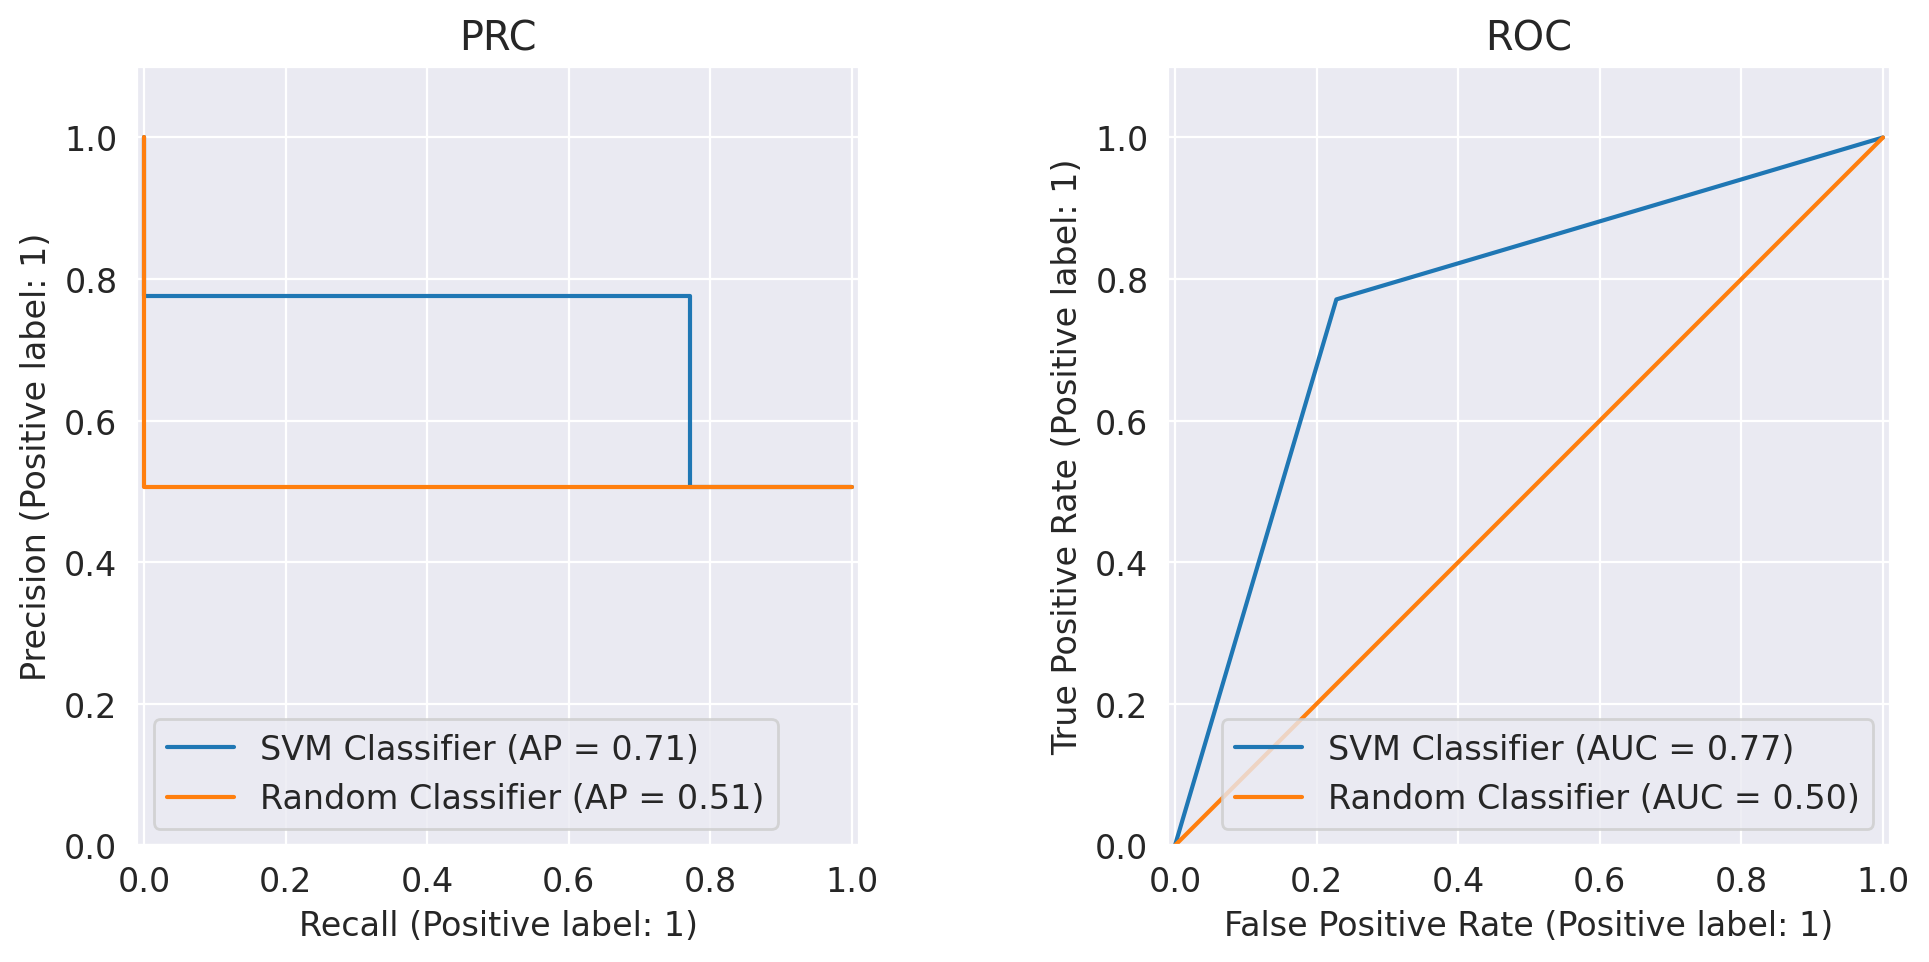

In [ ]:
# your code here
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
depict_pr_roc(y_test, svc_pred, 'SVM Classifier', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

dict_with_cs_for_log = {'C': np.logspace(0, 5, 20)}

new_searcher = GridSearchCV(LogisticRegression(max_iter=1000), param_grid = dict_with_cs_for_log, scoring="average_precision", cv=10)
new_searcher.fit(X_train, y_train)

best_c = searcher.best_params_['C']
log_reg = LogisticRegression(max_iter=1000, penalty = 'l2', C=best_c).fit(X_train, y_train)
log_pred = log_reg.predict(X_test)

# your code here

Logistic Classifier metrics
AUC-PR: 0.7138
AUC-ROC: 0.7713


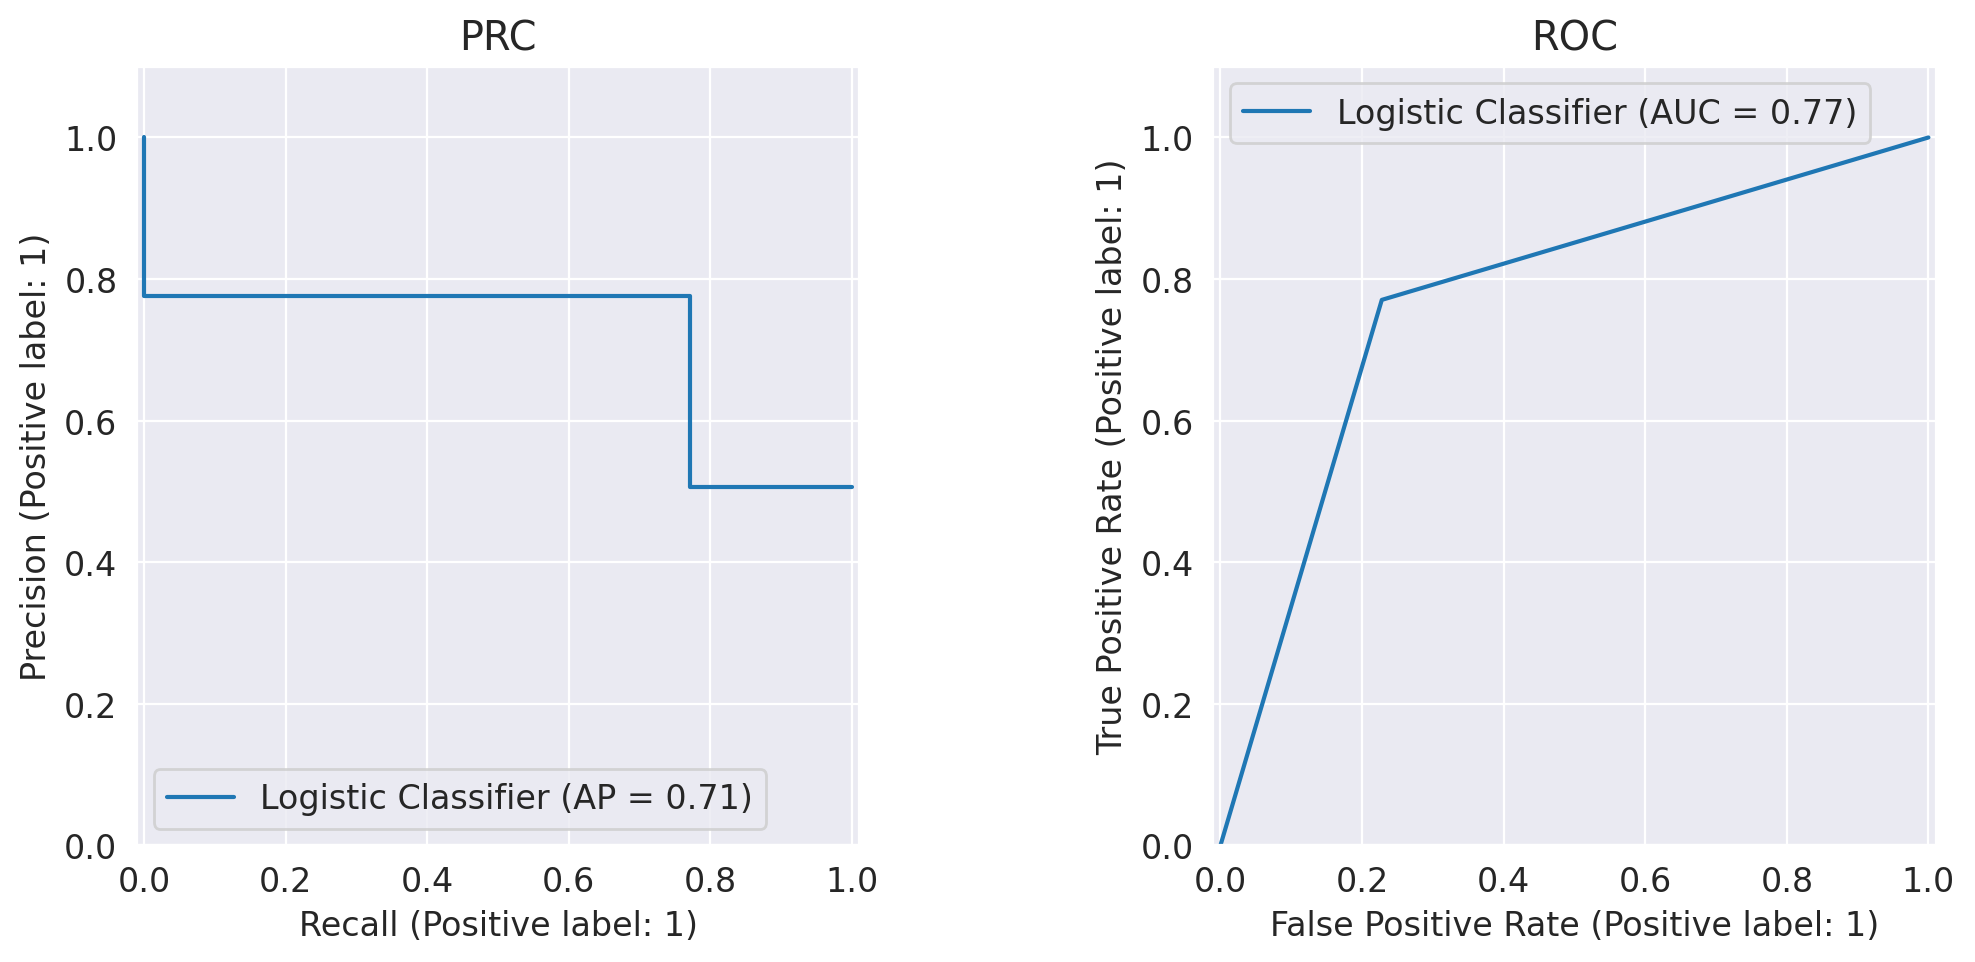

In [ ]:
depict_pr_roc(y_test, log_pred, 'Logistic Classifier')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

SVM Classifier metrics
AUC-PR: 0.7141
AUC-ROC: 0.7717
Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
Logistic Classifier metrics
AUC-PR: 0.7138
AUC-ROC: 0.7713


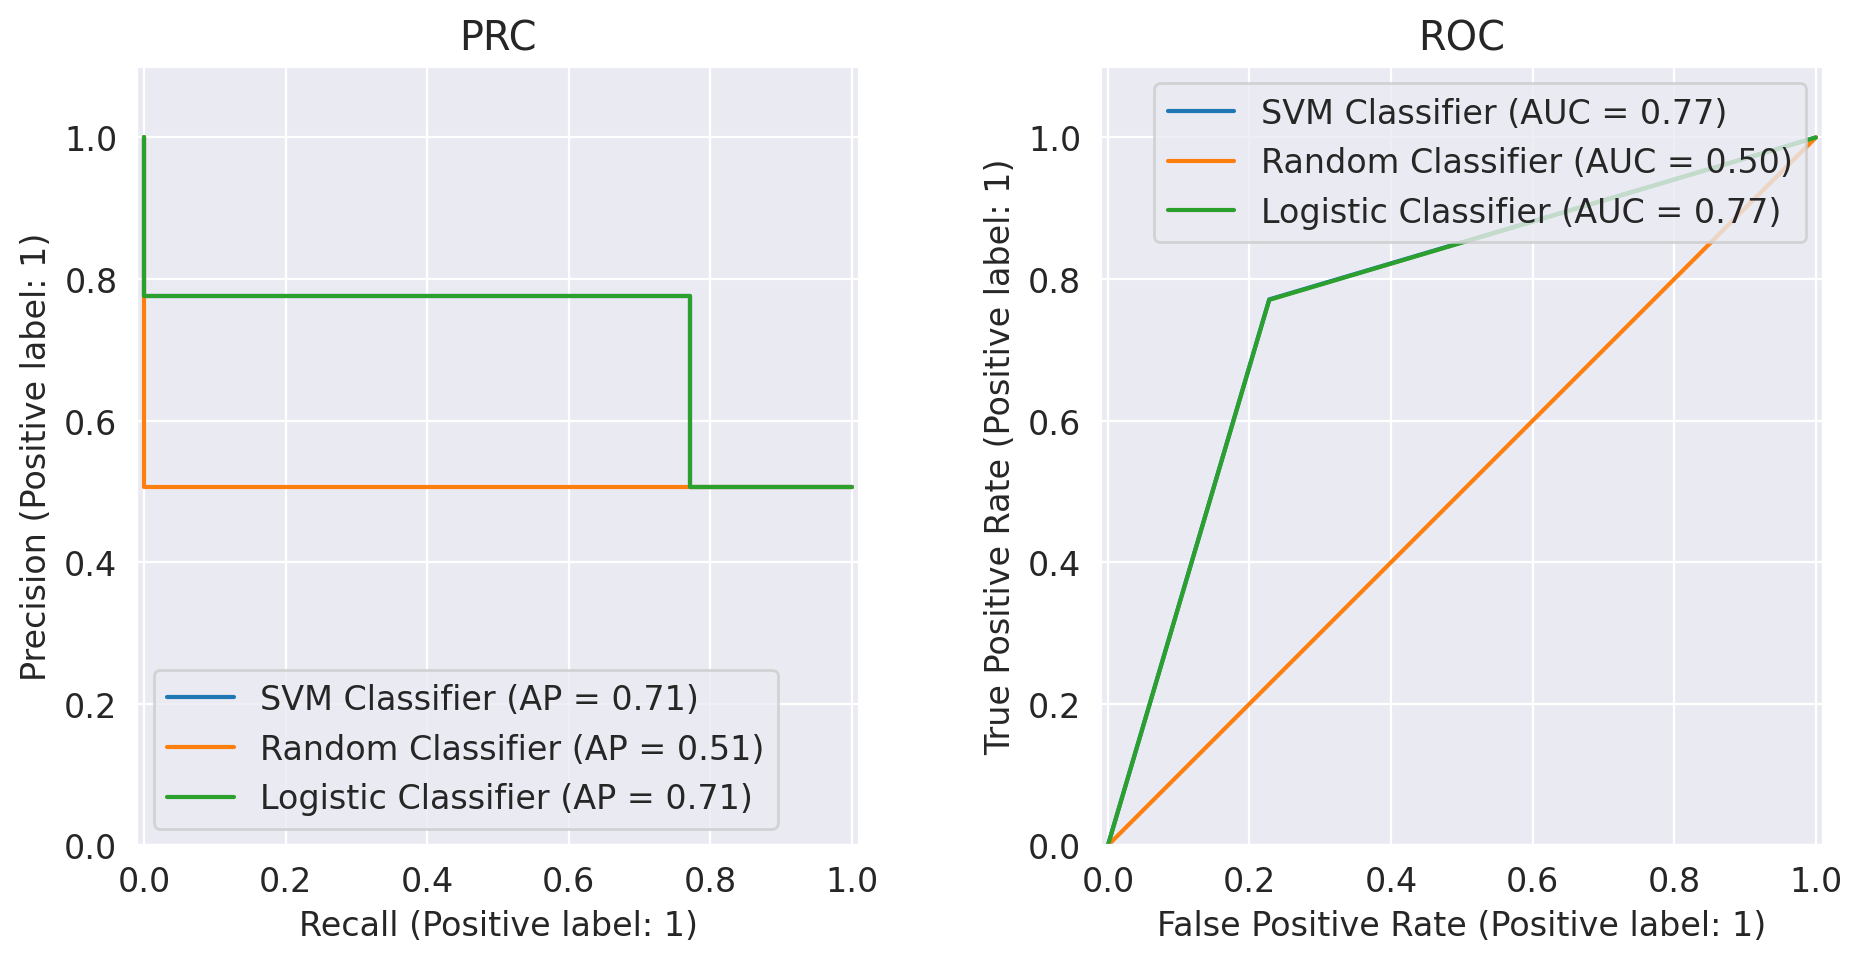

In [ ]:
# your code here
fig, ax = plt.subplots(1, 2, figsize = (11, 5))
depict_pr_roc(y_test, svc_pred, 'SVM Classifier', ax)
depict_pr_roc(y_test, y_random, 'Random Classifier', ax)
depict_pr_roc(y_test, log_pred, 'Logistic Classifier', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



Различия есть, но они незначительно малы. Скорее всего, это объясняется хорошей разделимостью данных(примерно одна и та же гиперплоскость), а также схожими метриками обучения.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

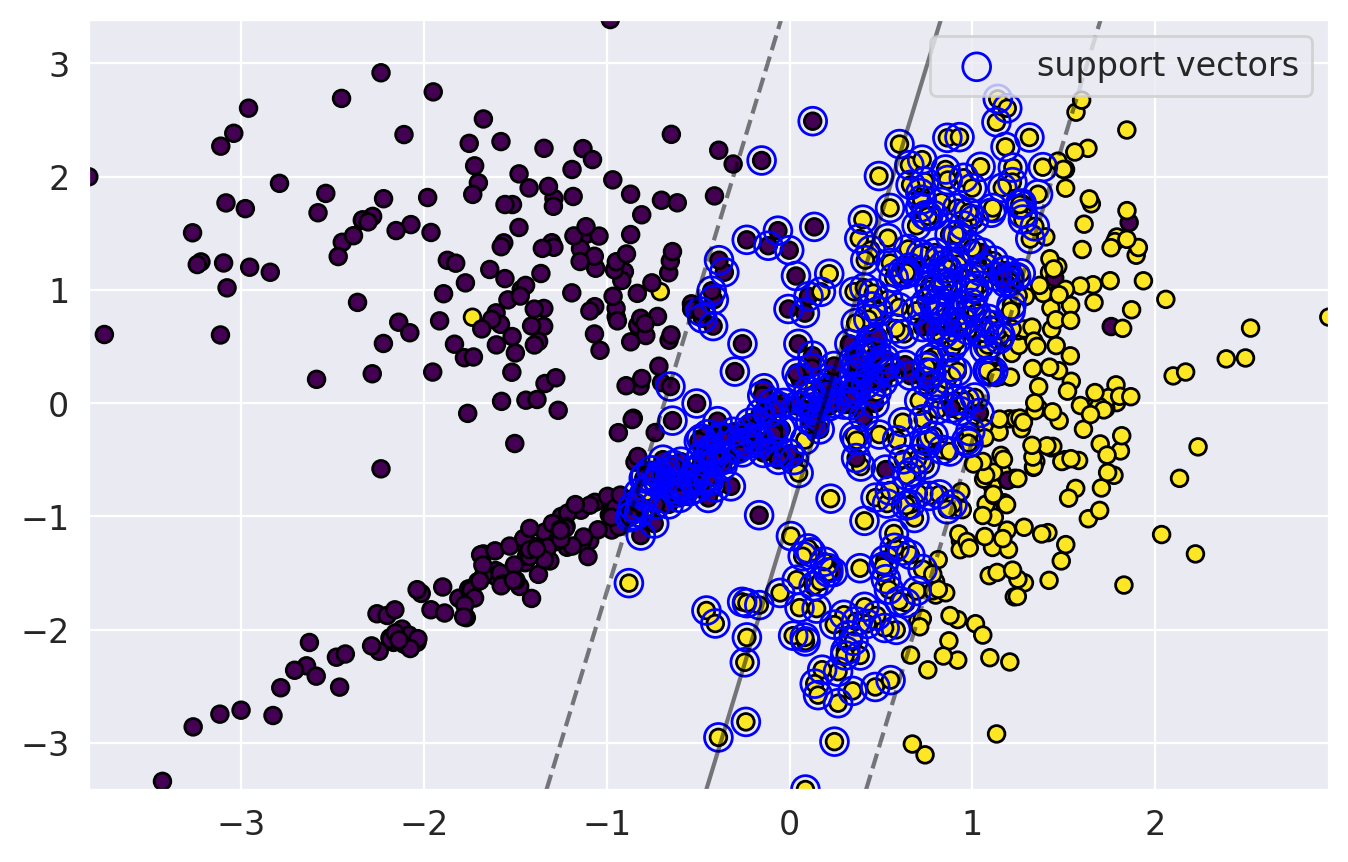

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape) #Z мы делаем двумерным, поскольку иначе у нас не получится достаточное количество точек

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')

    # Отрисовали опорные векторы
    if plot_support:
      decision_values = model.decision_function(X)
      support_vector_indices = np.where(np.abs(decision_values) <= 1)[0]
      support_vectors = X[support_vector_indices]
      plt.scatter(
            # your code here
            support_vectors[:, 0], support_vectors[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

X_train_another, y_train_another = make_classification(n_samples=900, n_features=2, n_informative = 2, n_redundant = 0, n_repeated = 0, random_state=52)

dict_with_cs_for_svm = {'C': np.logspace(0, 5, 20)}

new_searcher = GridSearchCV(LinearSVC(max_iter=1000), param_grid = dict_with_cs_for_svm, scoring="average_precision", cv=10)
new_searcher.fit(X_train_another, y_train_another)

best_c = searcher.best_params_['C']
model = LinearSVC(max_iter=1000, C=best_c).fit(X_train_another, y_train_another)
plot_svm_2D(X_train_another, y_train_another, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Мы знаем, что опорные векторы - это те векторы, для которых расстояние до разделяющей плоскости не превышает 1 по модулю. А функция решения в SVM возвращает как раз таки расстояние от точки до разделяющей гиперплоскости. Поэтому мы и задаем такое условие на опорные векторы.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

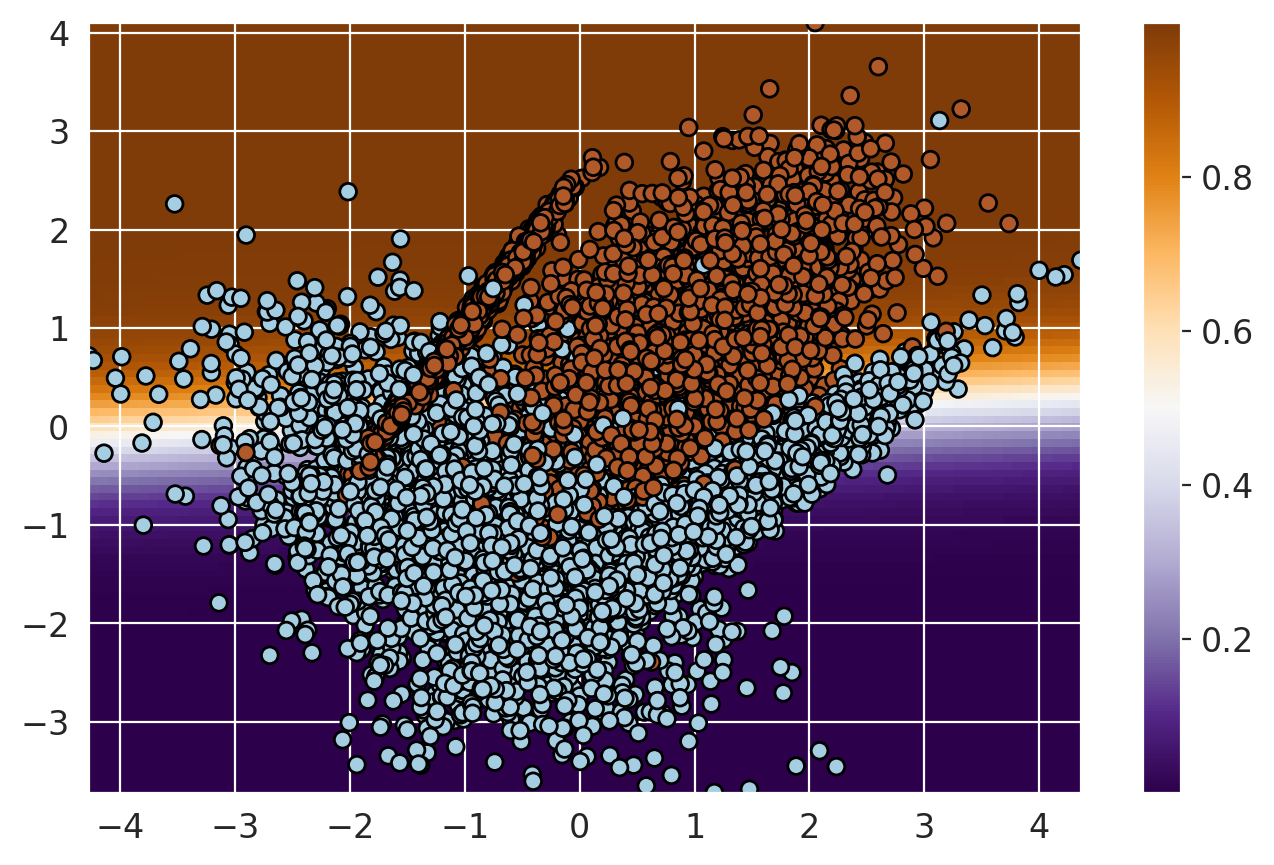

In [ ]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
        # your code here
        cmap=plt.cm.Paired,
        edgecolors='k'
    )

    plt.colorbar(image)

X, y = make_classification(n_samples=10000, n_features=2, n_informative = 2, n_redundant = 0, n_repeated = 0, random_state=52)

dict_with_cs_for_logistic = {'C': np.logspace(0, 5, 20)}

new_searcher = GridSearchCV(LinearSVC(max_iter=10000), param_grid = dict_with_cs_for_logistic, scoring="average_precision", cv=10)
new_searcher.fit(X, y)

best_c = searcher.best_params_['C']
model = LogisticRegression(max_iter=10000, C=best_c).fit(X, y)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Область, где модель не уверена, отображена на графике белым, то есть нейтральным цветом. Обосновать теоретически это можно так: чем цвет более синий - тем модель более уверена, что это отрицательный класс. Чем цвет более оранжевый - тем модель более уверена, что это положительный класс. Но вот когда вероятность 0,5 - то модель одинаково уверена в том, что это и положительный, и отрицательный классы, поэтому логичнее всего обозначать эту область нейтральным цветом, то есть, белым

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds, ax = None, label=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(bin_middle_points, bin_real_ratios, marker='o', label=label)
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Curve')
    ax.grid()
    plt.tight_layout()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [ ]:
# your code here
X_1, y_1 = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=52
)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.3, random_state=52)

In [ ]:
dict_with_cs_for_svm = {'C': np.logspace(0, 10, 50)}

new_searcher = GridSearchCV(LinearSVC(max_iter=10000), param_grid = dict_with_cs_for_svm, scoring="average_precision", cv=10)
new_searcher.fit(X_train_1, y_train_1)

best_c = searcher.best_params_['C']
svc_new = LinearSVC(max_iter=10000, C=best_c).fit(X_train_1, y_train_1)
svm_decision_values = svc_new.decision_function(X_test_1)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
preds_svc = sigmoid(svm_decision_values)

In [ ]:
dict_with_cs_for_logreg = {'C': np.logspace(0, 10, 50)}

new_searcher = GridSearchCV(LogisticRegression(max_iter=10000), param_grid = dict_with_cs_for_logreg, scoring="average_precision", cv=10)
new_searcher.fit(X_train_1, y_train_1)

best_c = searcher.best_params_['C']
log_new = LogisticRegression(max_iter=10000, C=best_c).fit(X_train_1, y_train_1)
preds_log = log_new.predict_proba(X_test_1)[:, 1]

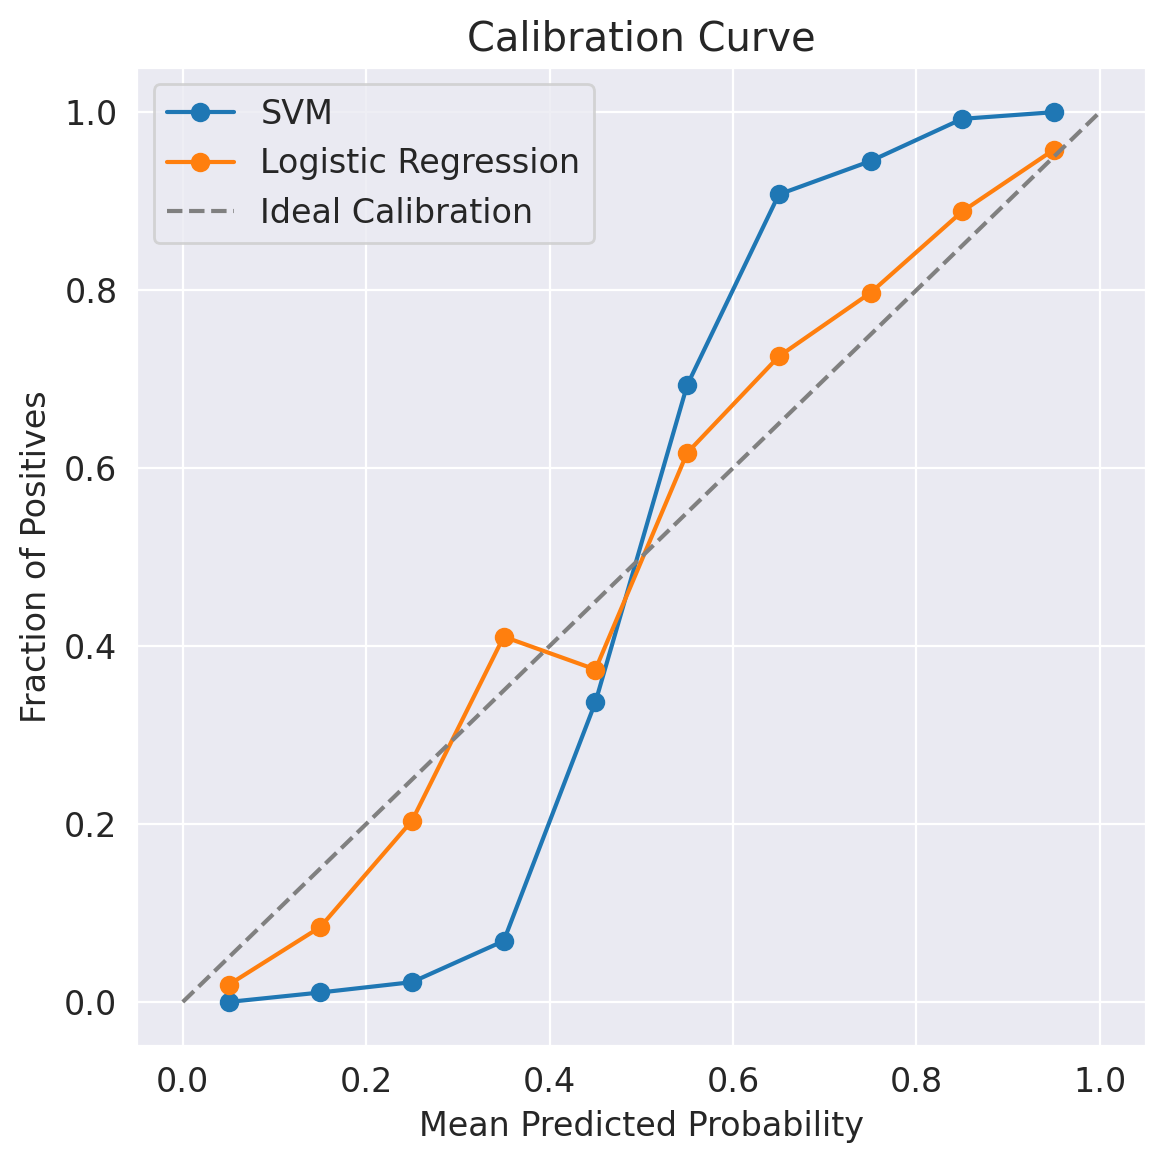

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
plot_calibration_curve(y_test_1, preds_svc, ax, label='SVM')
plot_calibration_curve(y_test_1, preds_log, ax, label='Logistic Regression')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration')
ax.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Нет, кривая для SVM плохо откалиброванна, поскольку она просто забивает на вероятности и не предсказывает их. SVM классификатор обладает хорошей разделяющей способностью, однако он не предсказывает вероятности. Его выход - это просто расстояние от объекта до разделяющей гиперплоскости. Поэтому он конечно хорошо разделяет классы(как мы видим из графика, у нас сначала идут практически все объекты отрицательного класса, а затем - положительного), но плохо предсказывает вероятности (как видим из графика, сначала во всех бинах у нас одинаково малая доля положительного класса, а затем - большая). Логистическая регрессия же наоброт стремится максимизировать уверенность в каждом объекте, а потому в итоге получает более приближенные к истинной вероятности выходы.



Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [ ]:
# your code here
from sklearn.metrics import log_loss, brier_score_loss
log_loss_logreg = log_loss(y_test_1, preds_log)
brier_score_logreg = brier_score_loss(y_test_1, preds_log)

log_loss_svm = log_loss(y_test_1, preds_svc)
brier_score_svm = brier_score_loss(y_test_1, preds_svc)

print(f"LogLoss (Logistic Regression): {log_loss_logreg:.4f}")
print(f"BrierScore (Logistic Regression): {brier_score_logreg:.4f}")
print(f"LogLoss (SVM with Sigmoid): {log_loss_svm:.4f}")
print(f"BrierScore (SVM with Sigmoid): {brier_score_svm:.4f}")

LogLoss (Logistic Regression): 0.2522
BrierScore (Logistic Regression): 0.0736
LogLoss (SVM with Sigmoid): 0.3872
BrierScore (SVM with Sigmoid): 0.1124


Чем ниже значение каждой из метрик - тем лучше модель предсказывает вероятность положительного класса для данного объекта. Как мы видим, логистическая регрессия в обоих случаях показвает более низкие значения метрик, а значит, лучше предсказывает вероятности.

Изучите распределение ответов классификаторов при помощи гистограмм

Text(0.5, 1.0, 'Logreg_Classifier')

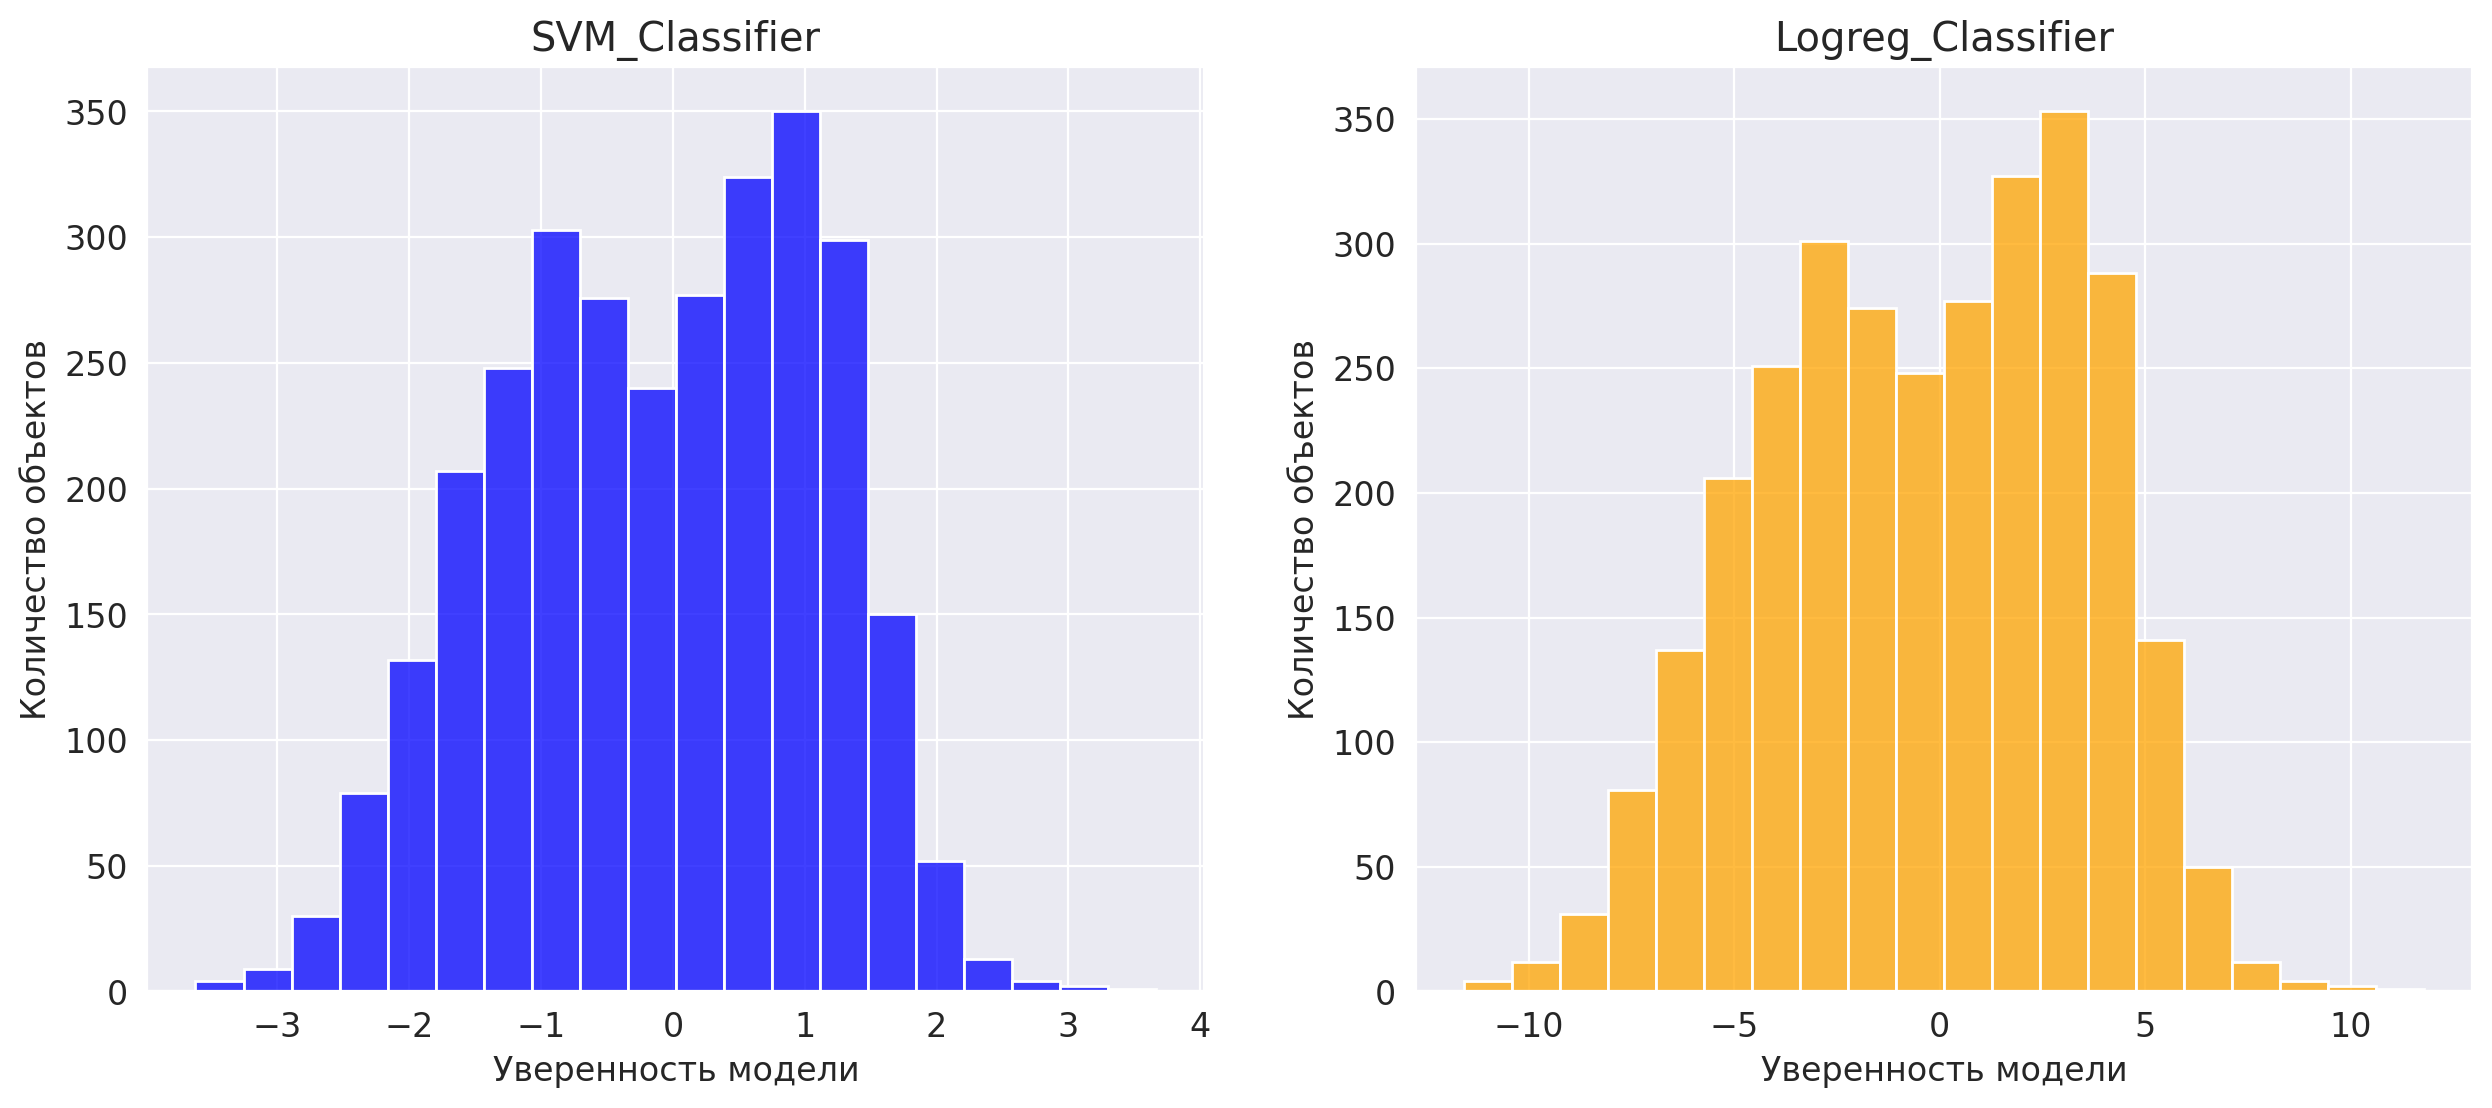

In [ ]:
# your code here
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
sns.histplot(svc_new.decision_function(X_test_1), ax = ax[0], bins = 20, color = 'blue')
ax[0].set_xlabel('Уверенность модели')
ax[0].set_ylabel('Количество объектов')
ax[0].set_title('SVM_Classifier')
sns.histplot(log_new.decision_function(X_test_1), ax = ax[1], bins = 20, color = 'orange')
ax[1].set_xlabel('Уверенность модели')
ax[1].set_ylabel('Количество объектов')
ax[1].set_title('Logreg_Classifier')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Как мы видим, разброс скоров модели для логистической регресии намного больше, чем разброс скоров для метода опорных векторов. Дело в том, что логистическая регрессия бесконечно убывает по уверенности (ее функция ошибки на объекте), а потому она будет стараться всегда максимизировать уверенность в объекте, то есть, выдавать скор по абсолютному значению как можно больше. В свою очередь, SVM становится равна нулю при margin, равном 1, а потому больше увеличивать уверенность для модели нет много смысла. А потому и разброс скоров ниже.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

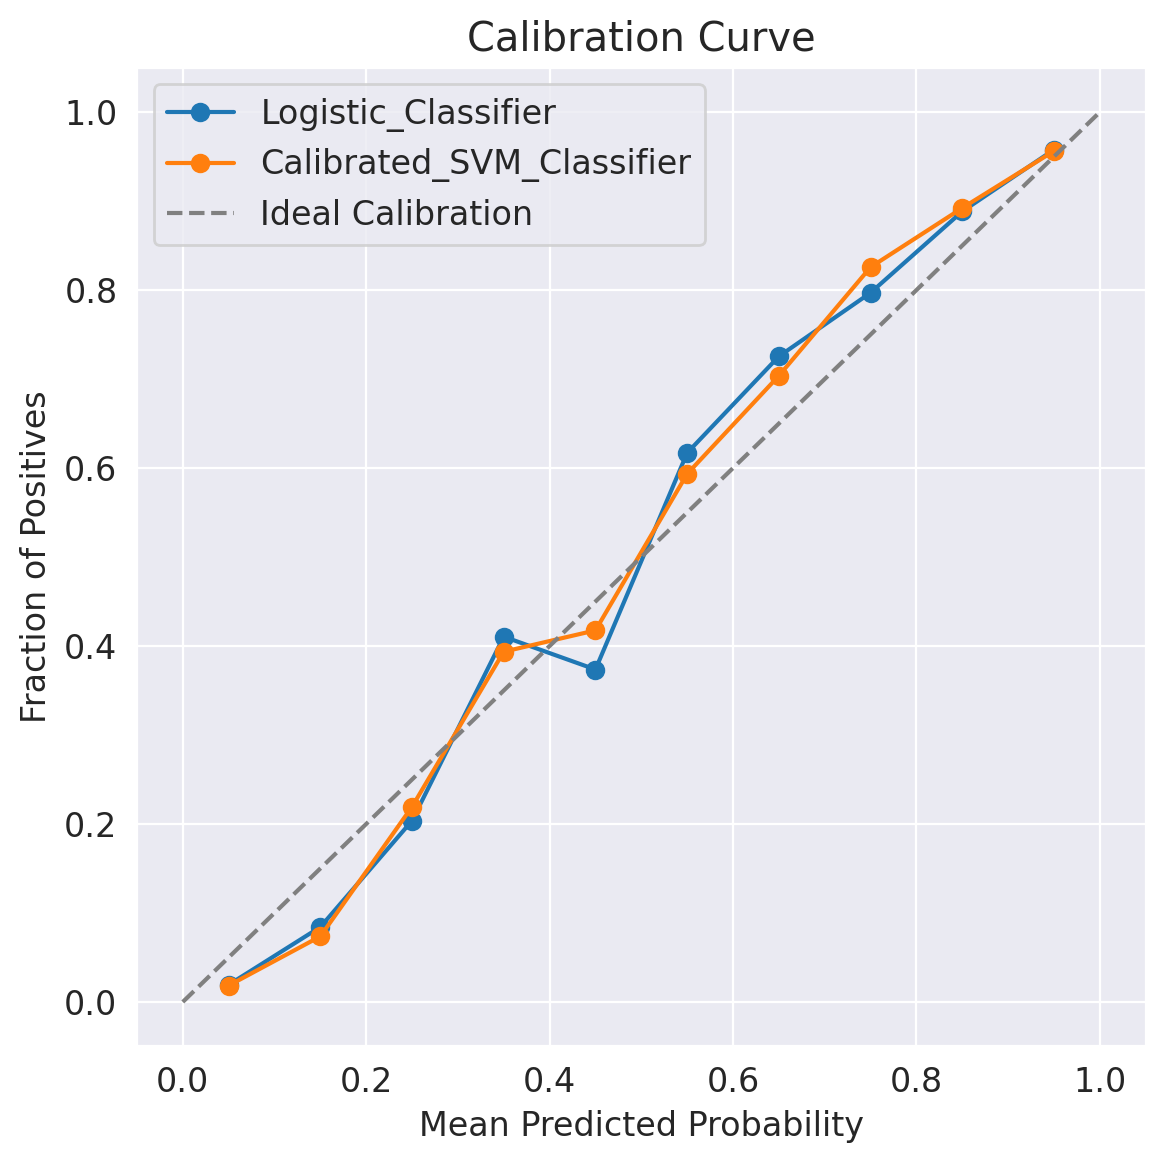

In [ ]:
# your code here
fig, ax = plt.subplots(figsize=(6,6))
from sklearn.calibration import CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(svc_new)
calibrated_svm.fit(X_train_1, y_train_1)
svm_preds = calibrated_svm.predict_proba(X_test_1)[:, 1]
plot_calibration_curve(y_test_1, preds_log, ax, label = "Logistic_Classifier")
plot_calibration_curve(y_test_1, svm_preds, ax, label = 'Calibrated_SVM_Classifier')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration')
ax.legend()
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да, калибровочная кривая намного улучшилась, а значит, калибровка сработала успешно

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [ ]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [ ]:
!wget  -O 'bike_buyers.csv' -q 'https://www.dropbox.com/scl/fi/sdx99hvc2t9t401dyfaqm/bike_buyers.csv?rlkey=11d9bq20xo07olo00n70iyp45&st=sugzhdlv&dl=0'

In [ ]:
data = pd.read_csv('bike_buyers.csv')

In [ ]:
data.loc[data['Purchased Bike'] == 'Yes', 'Purchased Bike'] = 1
data.loc[data['Purchased Bike'] == 'No', 'Purchased Bike'] = 0
data['Purchased Bike'] = data['Purchased Bike'].astype(int)

In [ ]:
# Прочитаем датасет
# your code here
data.head()

# Заменим пропуски категориальных переменных
# your code here
numerical = ['Income', 'Children', 'Cars', 'Age']
categorical = ['Marital Status', 'Gender', 'Education',
               'Occupation',	'Home Owner',	'Commute Distance',
               'Region',	'Purchased Bike']
data.loc[:, categorical] = data.loc[:, categorical].fillna('undefined')
# Отделим X и y
# your code here
y = data['Purchased Bike']
X = data.drop(columns='Purchased Bike')

# Разделим на категориальные признаки и числовые
X_numerical = X[numerical]
categorical_for_x = ['Marital Status', 'Gender', 'Education',
               'Occupation',	'Home Owner',	'Commute Distance',
               'Region']
X_categorical = X[categorical_for_x]

В начале поработаем только с категориальными признаками

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [ ]:
# your code here
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import time
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), categorical_for_x)
    ])
time_start = time.time()
X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)
dict_with_cs_for_logreg = {'C': np.logspace(0, 10, 50)}

new_searcher = GridSearchCV(LogisticRegression(max_iter=10000), param_grid = dict_with_cs_for_logreg, scoring="average_precision", cv=10)
new_searcher.fit(X_train_trans, y_train)

best_c = searcher.best_params_['C']
log_new = LogisticRegression().fit(X_train_trans, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_trans)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 3.2831995487213135
AUC-PR: 0.5887


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [ ]:
# your code here
from sklearn.preprocessing import OneHotEncoder
column_transformer_for_ohe = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical_for_x)
    ])
time_start = time.time()
X_train_tr_ohe = column_transformer_for_ohe.fit_transform(X_train)
X_test_tr_ohe = column_transformer_for_ohe.transform(X_test)
log_new = LogisticRegression().fit(X_train_tr_ohe, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_tr_ohe)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.02055978775024414
AUC-PR: 0.6663


Как мы видим, время на OHE увеличилось, поскольку создалось очень много категориальных признаков, однако качество модели улучшилось.

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [ ]:
# your code here
X_train_mean_en = X_train.copy()
X_test_mean_en = X_test.copy()
list_of_indexes = list(X_train.index)
data_with_needed_indexes = data.iloc[list_of_indexes]
time_start = time.time()
for category in categorical_for_x:
  encoded_category = data_with_needed_indexes.groupby(category)['Purchased Bike'].mean().to_dict()
  X_train_mean_en.loc[:, category] = X_train_mean_en[category].map(encoded_category)
  X_test_mean_en.loc[:, category] = X_test_mean_en[category].map(encoded_category)
log_new = LogisticRegression().fit(X_train_mean_en, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_mean_en)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.028163671493530273
AUC-PR: 0.6575


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [ ]:
# your code here
#данный класс был написан с помощью промптов чат GPT. Первый промпт был просто заданием. Затем было еще два промпта: первый
#сначала он создал код, где в качестве счетчика было количество объектов положительного класса, поэтому я попросил его исправить на среднее.
#второй промпт: попрсоил создать метод fit_transform просто чтобы трансформер был более полноценным
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.mean_dict = {} #здесь мы просто создали словарь, в который потом будем помещать серии со средними значениями для
        #каждой категории в данном столбце.

    def fit(self, X, y):
        df = X.copy() #создаем копию, чтобы могли снова добавить столбец с целевой переменной
        df['Purchased_bike'] = y
        for feature in self.categorical_features:
            self.mean_dict[feature] = df.groupby(feature)['Purchased_bike'].mean().to_dict() #просто проходимся по каждому столбцу
            #категориальных признаков, а затем в словаре сохраняем сериес со средними значениями для каждой категории
        return self

    def transform(self, X, y=None): #Метод transform не использует целевую переменную y,
    #но ее наличие в сигнатуре метода необходимо для совместимости с другими методами и пайплайнами scikit-learn.
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X_transformed[feature].map(self.mean_dict[feature]) #просто через map кодируем данные категории в данном
            #столбце соответствующим средним значением(в силу реализации метода map)
        return X_transformed

    def fit_transform(self, X, y=None, **fit_params): #прописываем **fit_params, т.к это
    #делает метод fit_transform более гибким и позволяет передавать дополнительные параметры при необходимости.
        self.fit(X, y)
        return self.transform(X, y)


In [ ]:
time_start = time.time()
targ_encoded = TargetEncoder(categorical_for_x)
X_train_mean_en = targ_encoded.fit_transform(X_train, y_train)
X_test_mean_en = targ_encoded.transform(X_test)
log_new = LogisticRegression().fit(X_train_mean_en, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_mean_en)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.025756120681762695
AUC-PR: 0.6575


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
# your code here
np.random.seed(50)
X_train_mean_en_noisy = X_train_mean_en.copy()
X_test_mean_en_noisy = X_test_mean_en.copy()
time_start = time.time()
for category in categorical_for_x:
  noise = np.random.normal(0, 0.04, size=X_train_mean_en[category].nunique())
  noisy_data = X_train_mean_en[category].unique() + noise
  list_of_features = list(X_train_mean_en[category].unique())
  dictionary = dict(zip(list_of_features, noisy_data))
  X_train_mean_en_noisy.loc[:, category] = X_train_mean_en_noisy[category].map(dictionary)
  X_test_mean_en_noisy.loc[:, category] = X_test_mean_en_noisy[category].map(dictionary)
log_new = LogisticRegression().fit(X_train_mean_en_noisy, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_mean_en_noisy)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.021735429763793945
AUC-PR: 0.6610


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Да, добавление шума помогло, поскольку теперь модель меньше подстраивается под данные из обучающей выборки, то есть она больше начинает быть готова к изменениям, а потому лучше предсказывает на тесте

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
# your code here
X_train_mean_en_gl = X_train.copy()
X_test_mean_en_gl = X_test.copy()
global_mean = y_train.mean()
C = 10
list_of_indexes = list(X_train.index)
data_with_needed_indexes = data.iloc[list_of_indexes]
for category in categorical_for_x:
  our_category_pos = data_with_needed_indexes.groupby(category)['Purchased Bike'].sum() + C * global_mean
  our_category_all = data_with_needed_indexes.groupby(category)['Purchased Bike'].count() + C
  encoded_category = (our_category_pos/our_category_all).to_dict()
  X_train_mean_en_gl.loc[:, category] = X_train_mean_en_gl[category].map(encoded_category)
  X_test_mean_en_gl.loc[:, category] = X_test_mean_en_gl[category].map(encoded_category)

In [ ]:
time_start = time.time()
log_new = LogisticRegression().fit(X_train_mean_en_gl, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_mean_en_gl)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.012253046035766602
AUC-PR: 0.6713


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



В нашем случае пропуски лучше заполнять медианой, потому что странно иметь объект с 3.5 детьми или 1.5 машинами.

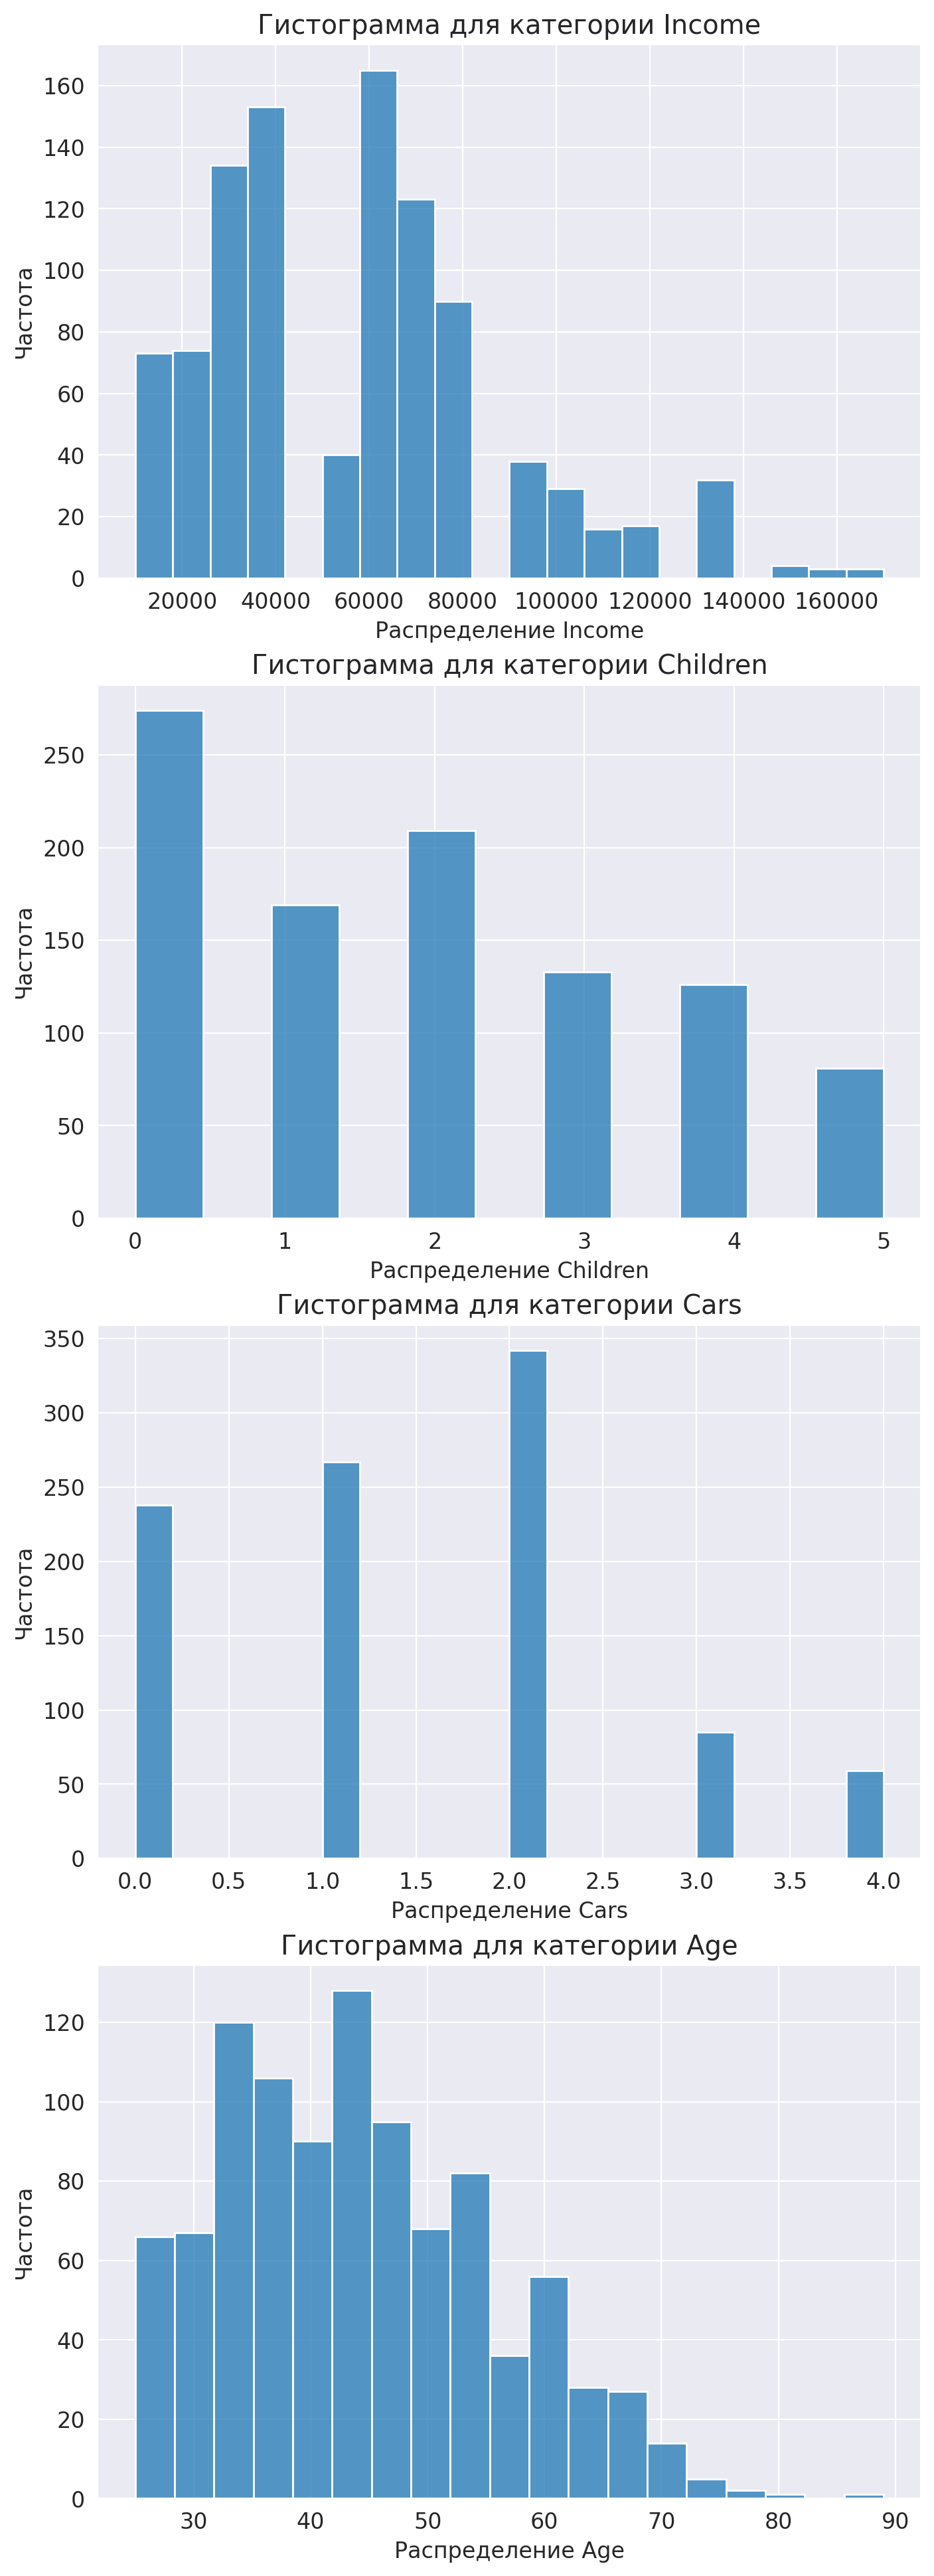

In [ ]:
# your code here
data.loc[:, numerical] = data[numerical].fillna(data[numerical].median())
fig, ax = plt.subplots(len(numerical), 1, figsize=(8, 6 * len(numerical)))
for i, category in enumerate(numerical):
    sns.histplot(X[category], ax=ax[i])
    ax[i].set_title(f'Гистограмма для категории {category}')
    ax[i].set_xlabel(f'Распределение {category}')
    ax[i].set_ylabel('Частота')
data_for_mask = data.copy()
mask = data['Income'] < np.quantile(data['Income'], 0.95)
data_for_mask = data_for_mask[mask]
mask1 = data_for_mask['Age'] < np.quantile(data_for_mask['Age'], 0.99)
data_for_mask = data_for_mask[mask1]
y = data_for_mask['Purchased Bike']
X = data_for_mask.drop(columns='Purchased Bike')
X = X.drop(columns='ID')

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [ ]:
for category in numerical:
  print(f'Количество уникальных объектов для {category}:', X[category].nunique())

Количество уникальных объектов для Income: 11
Количество уникальных объектов для Children: 6
Количество уникальных объектов для Cars: 5
Количество уникальных объектов для Age: 47


In [ ]:
# your code here
X = X.reset_index(drop = True)
data_for_mask = data_for_mask.reset_index(drop = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
list_of_columns = list(X_train.columns)
X_train_mean_en_gl = X_train.copy()
X_test_mean_en_gl = X_test.copy()
global_mean = y_train.mean()
C = 10
list_of_indexes = list(X_train.index)
data_with_needed_indexes = data.iloc[list_of_indexes]
for category in list_of_columns:
  our_category_pos = data_with_needed_indexes.groupby(category)['Purchased Bike'].sum() + C * global_mean
  our_category_all = data_with_needed_indexes.groupby(category)['Purchased Bike'].count() + C
  encoded_category = (our_category_pos/our_category_all).to_dict()
  X_train_mean_en_gl.loc[:, category] = X_train_mean_en_gl[category].map(encoded_category)
  X_test_mean_en_gl.loc[:, category] = X_test_mean_en_gl[category].map(encoded_category)

In [ ]:
time_start = time.time()
log_new = LogisticRegression().fit(X_train_mean_en_gl, y_train)
time_end = time.time() - time_start
print('Время, потребовавшееся на обучение модели, с учетом кодирования признаков:', time_end)
preds_log = log_new.predict_proba(X_test_mean_en_gl)[:, 1]
print('AUC-PR: %.4f' % average_precision_score(y_test, preds_log))

Время, потребовавшееся на обучение модели, с учетом кодирования признаков: 0.009398698806762695
AUC-PR: 0.7403


Как мы видим, AUC-PR стал намного лучше.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Во-первых, счетчики требуют намного меньше памяти, чем OHE, поскольку OHE создает огромное множество признаков, а при этом, счетчики просто заменяют наши признаки. Во-вторых, счетчики как будто просто легче создавать, поскольку OHE требует множественного бинарного создания признаков. С другой стороны, счетчики могут переобучаться на тех категориях, которые встречаются редко, потому что признак очень схож становится со всеми значениями целевой переменной. OHE не зависит от частоты встречаемости категорий, что делает его более устойчивым к переобучению.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 20:59:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.68MB/s    in 0.5s    

2024-11-28 20:59:39 (7.68 MB/s) - ‘adult.data’ saved [3974305]



In [ ]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
15223,31,Private,323069,Assoc-acdm,12,Divorced,Sales,Unmarried,White,Female,0,880,45,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [ ]:
# your code here

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [ ]:
# your code here

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
# your code here

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [ ]:
# your code here

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [ ]:
# your code here

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
# your code here

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
# your code here

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [ ]:
# your code here

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [ ]:
# your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [ ]:
# your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
# your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 20:59:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.40MB/s    in 0.3s    

2024-11-28 20:59:40 (1.40 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [ ]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [ ]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [ ]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|██████████| 87.2k/87.2k [00:00<00:00, 16.1MB/s]

Extracting files...


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here